# АНАЛИЗ ЗАПАСОВ ГОТОВОЙ ПРОДУКЦИИ

In [1]:
import itertools
import statsmodels.api as sm
import pandas as pd
from dataclasses import dataclass
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import warnings
import numpy as np
import pickle
import mplcyberpunk

plt.style.use("cyberpunk")
pd.set_option('mode.chained_assignment', None)
warnings.filterwarnings("ignore")


def load_data(filename="sales_extend.xlsx"):
    sales = pd.read_excel(filename)
    return sales


@dataclass
class SalesTimeSeries:
    data: pd.DataFrame
    item: str
    aggregation: str
    start_date: str
    end_date: str
    model: str = None
    predictions: float = None
    forecast: float = None
    table: float = None

    def transform(self):
        if self.item == 'All':
            self.data = self.data
        else:
            self.data = self.data[self.data['Номенклатура'] == self.item]
        month_mapping = {'Январь': 1, 'Февраль': 2, 'Март': 3, 'Апрель': 4, 'Май': 5, 'Июнь': 6, 'Июль': 7,
                         'Август': 8, 'Сентябрь': 9, 'Октябрь': 10, 'Ноябрь': 11, 'Декабрь': 12, }
        month = self.data['По месяцам'].str.replace(' г.', "").str.split(' ', expand=True)[0].map(month_mapping)
        year = self.data['По месяцам'].str.replace(' г.', "").str.split(' ', expand=True)[1]
        df = month.to_frame().join(year)
        df[0] = df[0].astype('str')
        df[1] = df[1].astype('str')
        df['date'] = df[0] + '-' + df[1]
        df['date'] = pd.to_datetime(df['date'])
        self.data['По месяцам'] = df['date']
        self.data = self.data.set_index('По месяцам')['Количество']
        self.data = self.data[(self.data.index >= self.start_date) & (self.data.index <= self.end_date)]
        self.data = self.data.groupby(pd.Grouper(freq=self.aggregation)).sum()

    def train(self):
        p = d = q = range(0, 2)
        pdq = list(itertools.product(p, d, q))
        seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

        res_aic = 9999
        arima_param = 0
        arima_param_seas = 0

        for param in pdq:
            for param_seasonal in seasonal_pdq:
                try:
                    mod = sm.tsa.statespace.SARIMAX(self.data,
                                                    order=param,
                                                    seasonal_order=param_seasonal,
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)
                    self.model = mod.fit()
                    if self.model.aic < res_aic:
                        res_aic = self.model.aic
                        arima_param = param
                        arima_param_seas = param_seasonal
                except:
                    continue

        mod = sm.tsa.statespace.SARIMAX(self.data,
                                        order=arima_param,
                                        seasonal_order=arima_param_seas,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        self.model = mod.fit()

    def predict(self):
        self.predictions = self.model.get_prediction(start=self.data.index[0]).predicted_mean

    def make_forecast(self):
        self.forecast = self.model.get_forecast(steps=12).predicted_mean
        
    
    def make_data_table(self):
        self.table = pd.DataFrame(self.forecast).reset_index().rename(columns={'index': 'End_date'})
        self.table['Begin_date'] = self.table['End_date'].astype(str).str[:7] + '-' + '01'
        self.table['Begin_date'] = pd.to_datetime(self.table['Begin_date'])
        self.table['bd_number'] = np.busday_count(begindates=self.table['Begin_date'].values.astype('datetime64[D]'), 
                                                     enddates=self.table['End_date'].values.astype('datetime64[D]'))
        self.table['sales_per_day'] = self.table['predicted_mean'] / self.table['bd_number']
        self.table['MAPE'] = np.mean(np.abs((self.data - self.predictions) / self.data)) * 100

    def plot_time_series(self):
        plt.figure(figsize=(10, 4))
        plt.plot(self.data.index, self.data, marker='o', markersize=3, c='#08f5fd') # 7FFFD4
        plt.xlabel('Date')
        plt.ylabel('Quantity')
        plt.title(f"{self.item} Time series plot")
        plt.grid(linestyle='--', c='grey')
        plt.tight_layout()

        mplcyberpunk.add_glow_effects()
        mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.5, gradient_start='bottom')
        plt.show()

    def plot_predictions(self):
        plt.figure(figsize=(10, 4))

        plt.plot(self.data.index, self.data, marker='o', markersize=3, c='#08f5fd')
        plt.plot(self.predictions.index, self.predictions, marker='o', markersize=3, c='red')

        plt.xlabel('Date')
        plt.ylabel('Quantity')
        plt.title(f"{self.item} Actual vs predicted plot")
        plt.grid(linestyle='--', c='grey')
        plt.tight_layout()

        mplcyberpunk.add_glow_effects()
        mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.5, gradient_start='bottom')
        plt.show()

    def plot_forecast(self):
        plt.figure(figsize=(10, 4))
        plt.plot(self.forecast.index, self.forecast, marker='o', markersize=5, c='#08f5fd', mfc='red')
        plt.xlabel('Date')
        plt.ylabel('Quantity')
        plt.title(f"{self.item} Forecast plot", pad=20)
        plt.grid(linestyle='--', c='grey')
        plt.xticks(self.forecast.index, rotation=90)
        for x, y in zip(self.forecast.index, self.forecast):
            label = y
            plt.annotate(f"{round(label):,}", (x, y),
                         xycoords="data",
                         textcoords="offset points",
                         xytext=(0, 10), ha="center")
        plt.tight_layout()

        mplcyberpunk.add_glow_effects()
        mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.5, gradient_start='bottom')
        plt.show()

    def show_metrics(self):
        mape = np.mean(np.abs((self.data - self.predictions) / self.data)) * 100
        me = np.mean(self.predictions - self.data)
        mae = np.mean(np.abs(self.predictions - self.data))
        mpe = np.mean((self.predictions - self.data) / self.data)
        rmse = np.mean((self.predictions - self.data) ** 2) ** .5
        corr = np.corrcoef(self.predictions, self.data)[0, 1]
        mins = np.amin(np.hstack([self.predictions[:, None],
                                  self.data[:, None]]), axis=1)
        maxs = np.amax(np.hstack([self.predictions[:, None],
                                  self.data[:, None]]), axis=1)
        minmax = 1 - np.mean(mins / maxs)

        metrics = {'mape': mape, 'me': me, 'mae': mae,
                   'mpe': mpe, 'rmse': rmse, 'corr': corr, 'minmax': minmax}
        print(metrics)

    def save_forecast(self):
        self.forecast.to_excel("forecast.xlsx")

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## ЗАГРУЗКА ДАННЫХ О ПРОДАЖАХ

In [2]:
sales = load_data()

## ЗАГРУЗКА АКТУАЛЬНОГО СПИСКА ГОТОВОЙ ПРОДУКЦИИ

In [3]:
actual_items = pd.read_excel('actual_items.xlsx')
actual_items.head()

,item,production_line
0,Аир корневища 75г,Линия ББЛ
1,Алтей корни 75г,Линия ББЛ
2,Багульник болотный побеги 50г,Линия ББЛ
3,Береза почки 50г,Линия ББЛ
4,Бессмертник песчаный цветки 30г,Линия ББЛ


## РАСЧЕТ ПРОГНОЗА ПРОДАЖ ПО КАЖДОМУ НАИМЕНОВАНИЮ

In [4]:
time_series = {}
start_date = '2012-01-01'
end_date = '2022-10-01'
for item in actual_items.item.unique():
    data = SalesTimeSeries(data=sales, item=item, aggregation='M', start_date=start_date, end_date=end_date)
    data.transform()
    data.train()
    data.predict()
    data.make_forecast()
    data.make_data_table()
    time_series[item] = data.table

## ЭКСПОРТ ПРОГНОЗА В ФАЙЛ

In [5]:
with open('time_series_10_22.pkl', 'wb') as f:
    pickle.dump(time_series, f)

## ИМПОРТ ПРОГНОЗА ИЗ ФАЙЛА

In [6]:
with open('time_series_10_22.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

## ЗАГРУЗКА ОСТАТКОВ ГОТОВОЙ ПРОДУКЦИИ

In [7]:
stocks = pd.read_excel('finish_goods_stocks.xlsx')
stocks.head()

,Наименование,Количество
0,ВердиоГаст® Растительный комплекс для улучшени...,81632.0
1,Чага (березовый гриб) 50г,17570.0
2,Спорыш трава 50г,11335.0
3,Сб. Фитогепатол №2 (Желчегонный сбор №2) 35г,3181.0
4,Солодка корни 50г,31238.0


In [8]:
def calculate_stock_level(item, stocks, forecast):
    date_index = pd.date_range(start=forecast[item]['Begin_date'].iloc[0], 
                end=forecast[item]['End_date'].iloc[-1], freq='B')
    temp = pd.DataFrame(index=date_index)
    current_date = pd.to_datetime('today').normalize()
    temp = temp[temp.index>=current_date]
    temp['Остаток'] = stocks[stocks['Наименование'] == item]['Количество'].item()
    i = 0
    dead_line = 0
    stock_level = 0
    for date, stock in temp.iterrows():
        year = date.year
        month = date.month
        stat = forecast[item][(forecast[item]['End_date'].dt.year == year) & (forecast[item]['End_date'].dt.month == month)]
        sales_per_day = stat['sales_per_day'].item()
        if i == 0:
            temp['Остаток'].iloc[i] == temp['Остаток'][i]
        else:
            temp['Остаток'].iloc[i] = temp['Остаток'].iloc[i - 1] - sales_per_day
            if temp['Остаток'].iloc[i] < 0:
                temp['Остаток'].iloc[i:] = 0
                stock_level = temp.astype(bool).sum(axis=0).item()
                temp['DeadLine'] = 0
                if i <= 0:
                    temp['DeadLine'].iloc[0] = 'DeadLine'
                else:
                    temp['DeadLine'].iloc[i - 6] = 'DeadLine'
                dead_line = temp[temp['DeadLine'] == 'DeadLine'].index
                dead_line = pd.Series(dead_line.format())[0]
                break
            if i == temp.shape[0] - 1:
                stock_level = temp.astype(bool).sum(axis=0).item()
                break
        i += 1
    item_stock = stocks[stocks['Наименование'] == item]['Количество'].item()
    mape = forecast[item]['MAPE'][0]
    
    return item_stock, stock_level, mape, temp, dead_line

In [9]:
final_data = {}
for idx, row in actual_items.iterrows():
    item_stock, stock_level, mape, temp_data, dead_line = calculate_stock_level(row[0], stocks, loaded_dict)
    final_data[row[0]] = [row[1], stock_level, item_stock, round(mape, 0), temp_data, dead_line]

In [10]:
final_table = (pd.DataFrame.from_dict(final_data, orient='index')
.rename(columns={0: 'Линия производства', 
                 1: 'Запасы (дней)', 
                 2: 'Остатки (шт.)', 
                 3: 'MAPE',
                 5: 'DeadLine'})
.sort_values(by=['Линия производства', 'Запасы (дней)'])
.drop(4, 1))

In [11]:
final_table.head(10)

,Линия производства,Запасы (дней),Остатки (шт.),MAPE,DeadLine
"ВердиоГаст® Растительный комплекс для улучшения пищеварения (БАД ), капсулы",Контрактная площадка,254,81632.0,74.0,0
Чага (березовый гриб) 50г,Линия ББЛ,9,17570.0,45.0,2022-11-15
Сб. Фитогепатол №2 (Желчегонный сбор №2) 35г,Линия ББЛ,16,3181.0,37.0,2022-11-24
Чистотел трава 50г,Линия ББЛ,16,13635.0,37.0,2022-11-24
Дуба кора 75г,Линия ББЛ,18,64575.0,30.0,2022-11-28
Спорыш трава 50г,Линия ББЛ,18,11335.0,32.0,2022-11-28
Полынь горькая трава 50г,Линия ББЛ,19,36512.0,29.0,2022-11-29
Сенна листья 50г,Линия ББЛ,19,17849.0,33.0,2022-11-29
Мать-и-мачеха листья 35г,Линия ББЛ,20,22948.0,44.0,2022-11-30
Шиповник плоды низковитаминные 50г,Линия ББЛ,20,25485.0,92.0,2022-11-30


## ЭКСПОРТ ДАННЫХ В EXCEL

In [12]:
final_table.to_excel('stock_analysis.xlsx')

## ВИЗУАЛИЗАЦИЯ

In [13]:
from ipywidgets import widgets

selected_item = widgets.Dropdown(
    options=actual_items.item.unique(),
    value='Аир корневища 75г',
    description='Item:',
)
selected_item

Dropdown(description='Item:', options=('Аир корневища 75г', 'Алтей корни 75г', 'Багульник болотный побеги 50г'…

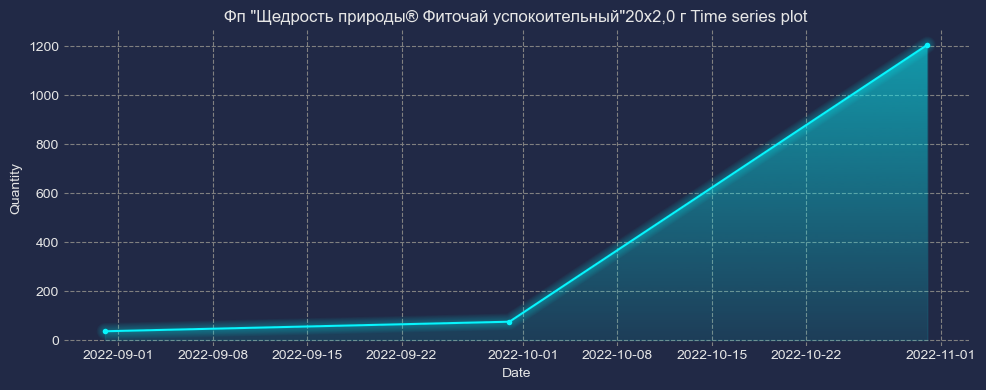

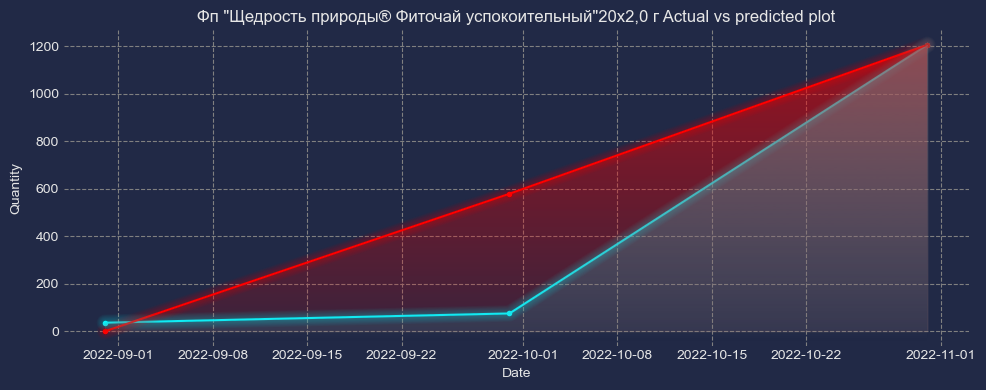

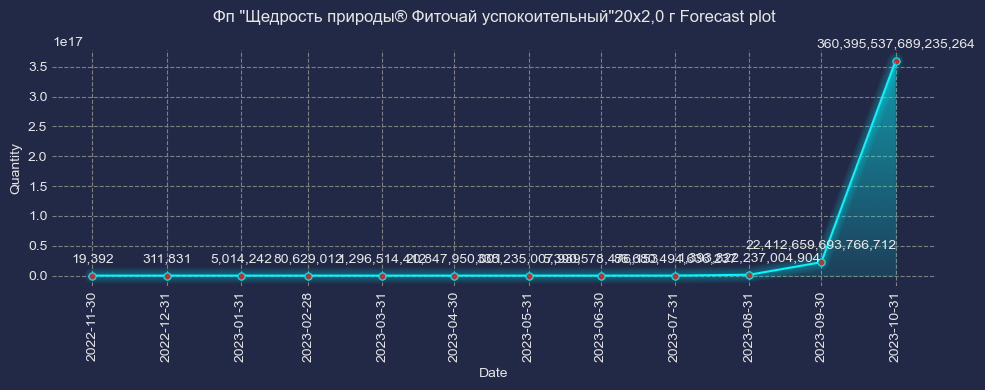

{'mape': 257.27998124235137, 'me': 155.95995016647564, 'mae': 179.9600175090786, 'mpe': 1.9061330899172093, 'rmse': 291.65676490073474, 'corr': 0.8910421112136282, 'minmax': 0.6234798474092011}


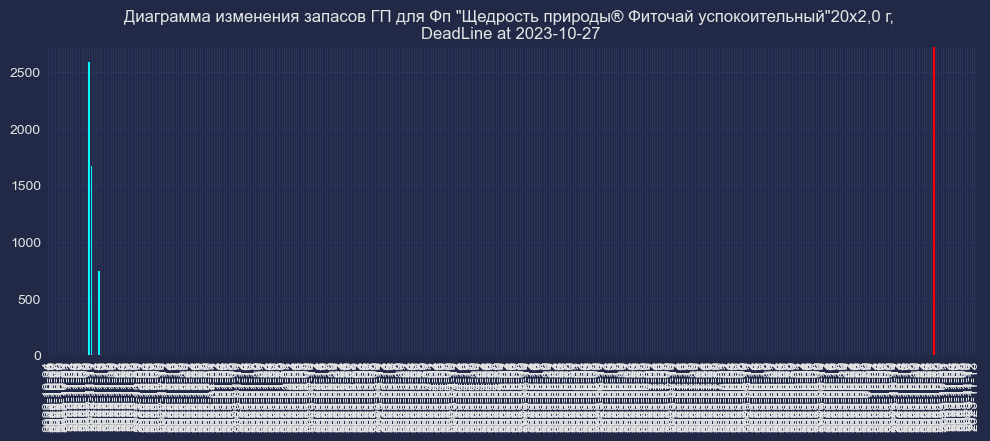

In [65]:
temp = SalesTimeSeries(data=sales, item=selected_item.value, aggregation='M', start_date='2012-01-01', end_date='2022-10-01')
temp.transform()
temp.train()
temp.predict()
temp.make_forecast()
temp.make_data_table()
temp.plot_time_series()
temp.plot_predictions()
temp.plot_forecast()
temp.show_metrics()

fig, ax = plt.subplots(figsize=(12, 4))
nl = '\n'
idx = (final_data[selected_item.value][4]['Остаток'] > 0).sum() + 1
dead_line = final_data[selected_item.value][4][final_data[selected_item.value][4]['DeadLine'] == 'DeadLine'].index
ax.bar(final_data[selected_item.value][4].iloc[:idx].index, final_data[selected_item.value][4].iloc[:idx]['Остаток'])
ax.axvline(x=dead_line, ymin=0, ymax=final_data[selected_item.value][4].head(20)['Остаток'].max(), color='red', zorder=2)
ax.set_title(f'Диаграмма изменения запасов ГП для {selected_item.value}, {nl}DeadLine at {dead_line.strftime("%Y-%m-%d")[0]}')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
myFmt = DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(myFmt)
ax.tick_params(axis='x', rotation=90);